# 0.0 Imports

In [ ]:
# !pip install inflection
# !pip install pandas-profiling
# !pip install sweetviz
# !pip install xgboost
# !pip install lightgbm
# !pip install catboost


In [50]:
import inflection
import numpy as np
import pandas as pd
import seaborn as sns
#import pandas-profile
import sweetviz
from scipy import stats
from itertools import product

from matplotlib import pyplot as plt
from sklearn.preprocessing import RobustScaler, MinMaxScaler, LabelEncoder
from sklearn import model_selection as ms
from sklearn.metrics import accuracy_score, classification_report,precision_score
from sklearn               import model_selection as ms
from sklearn               import ensemble        as en
from sklearn               import neighbors       as nh
from sklearn.linear_model import LogisticRegression

from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

/shared-libs/python3.9/py/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning:

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html



In [194]:
test_data = pd.read_csv('/data/test.csv')
train_data = pd.read_csv('/data/train.csv')

X = train_data.drop(columns=['Satisfaction'])
y = train_data['Satisfaction'].copy()

x_train, x_val, y_train, y_val = ms.train_test_split(X, y, test_size=0.2, random_state=42)

df1 = pd.concat([x_train, y_train],axis=1)

In [4]:
def notebook_settings():
    %matplotlib inline
    plt.style.use('bmh')
    plt.rcParams['figure.figsize'] = [25,10]
    plt.rcParams['font.size'] = 24
    plt.rcParams['figure.dpi'] = 100
    
    pd.set_option('display.float_format', lambda x: '%.3f' % x)

notebook_settings()

# 1.0 Descrição dos dados

In [5]:
df1.head()

,id,Gender,Customer Type,Age,Type of Purchase,Store size,Store distance,InStore wifi,Open/Close time convenient,Easy of online shopping,...,Kids entertainment,Seller service,Showroom,Self-Store,Purchase service,Store Service,Cleanliness,Carrier delay in minutes,Delivery delay in minutes,Satisfaction
20921,37164,Female,Loyal Customer,59,Personal,Medium,1046,4,5,4,...,2,2,4,3,5,2,4,12,3.000,Neutral or Dissatisfaction
36897,43436,Female,disloyal Customer,40,Gift,Large,752,4,4,4,...,1,4,2,4,3,5,1,19,29.000,Neutral or Dissatisfaction
8468,5306,Male,Loyal Customer,65,Personal,Medium,383,2,3,2,...,1,5,4,5,5,5,1,0,0.000,Neutral or Dissatisfaction
53490,79161,Female,Loyal Customer,70,Personal,Medium,2239,3,5,3,...,5,5,3,5,3,5,5,0,0.000,Neutral or Dissatisfaction
78687,33333,Female,disloyal Customer,25,Gift,Medium,1358,2,2,2,...,1,1,2,3,5,2,1,3,15.000,Neutral or Dissatisfaction


In [6]:
df1.shape

(83123, 24)

In [195]:
# train data
old_cols = df1.columns
snakecase = lambda x : inflection.parameterize(x, separator='_')
new_cols = list(map(snakecase, old_cols))
df1.columns = new_cols

# val data
old_cols = x_val.columns
snakecase = lambda x : inflection.parameterize(x, separator='_')
new_cols = list(map(snakecase, old_cols))
x_val.columns = new_cols

# test data
old_cols = test_data.columns
snakecase = lambda x : inflection.parameterize(x, separator='_')
new_cols = list(map(snakecase, old_cols))
test_data.columns = new_cols

- Store distance - se refere a distância do cliente para a loja ou a distância da loja concorrente mais próxima

- InStore wifi - Corresponde ao número de roteador? Validar essa hipótese comparando com o tamanho da loja.

 Também pode ser a qualidade do wifi, se for então deverá ter muitos dados dispersos.

- Ter uma descrição das colunas com base no conhecimento de negocio de loja de roupas

- Self-store: poderia ser um painel para auto-atendimento

In [8]:
df1.isna().sum()

id                              0
gender                          0
customer_type                   0
age                             0
type_of_purchase                0
store_size                      0
store_distance                  0
instore_wifi                    0
open_close_time_convenient      0
easy_of_online_shopping         0
store_location                  0
toilet_cleaning                 0
dressing_room                   0
waiting_room                    0
kids_entertainment              0
seller_service                  0
showroom                        0
self-store                      0
purchase_service                0
store_service                   0
cleanliness                     0
carrier_delay_in_minutes        0
delivery_delay_in_minutes     251
satisfaction                    0
dtype: int64

- Hip 1: Quem não preencheu Delivery delay in minutes foi porque comprou em loja física

- Hip 2: Quem não preencheu Delivery delay in minutes foi porque estava insatisfeito

In [196]:
# train data
df1['delivery_delay_in_minutes'] = df1['delivery_delay_in_minutes'].fillna(0)

# val data
x_val['delivery_delay_in_minutes'] = x_val['delivery_delay_in_minutes'].fillna(0)

# test data
test_data['delivery_delay_in_minutes'] = test_data['delivery_delay_in_minutes'].fillna(0)

In [10]:
df1.dtypes

id                              int64
gender                         object
customer_type                  object
age                             int64
type_of_purchase               object
store_size                     object
store_distance                  int64
instore_wifi                    int64
open_close_time_convenient      int64
easy_of_online_shopping         int64
store_location                  int64
toilet_cleaning                 int64
dressing_room                   int64
waiting_room                    int64
kids_entertainment              int64
seller_service                  int64
showroom                        int64
self-store                      int64
purchase_service                int64
store_service                   int64
cleanliness                     int64
carrier_delay_in_minutes        int64
delivery_delay_in_minutes     float64
satisfaction                   object
dtype: object

In [197]:
df1['delivery_delay_in_minutes'] = df1['delivery_delay_in_minutes'].astype('int64')

x_val['delivery_delay_in_minutes'] = x_val['delivery_delay_in_minutes'].astype('int64')

test_data['delivery_delay_in_minutes'] = test_data['delivery_delay_in_minutes'].astype('int64')

In [12]:
numerical_attributes = df1.select_dtypes(include='number')
categorical_attributes = df1.select_dtypes(exclude='number')

# Central tendency and Dispersion
d1 = pd.DataFrame (numerical_attributes.apply( lambda x: x.max() - x.min() )).T
d2 = numerical_attributes.agg(['min', 'max', 'mean', 'median', 'std', 'skew', 'kurtosis'])

# concatenate
metrics = pd.concat([d1, d2]).T.reset_index()
metrics.columns = ['attibutes', 'range', 'min', 'max', 'mean', 'median', 'std', 'skew', 'kurtosis']
metrics = metrics[['attibutes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']]

metrics

,attibutes,min,max,range,mean,median,std,skew,kurtosis
0,id,1.000,129879.000,129878.000,65059.540,65078.000,37425.968,-0.002,-1.197
1,age,7.000,85.000,78.000,39.341,40.000,15.124,0.001,-0.722
2,store_distance,31.000,4983.000,4952.000,1188.665,842.000,996.941,1.110,0.271
3,instore_wifi,0.000,5.000,5.000,2.730,3.000,1.328,0.037,-0.846
4,open_close_time_convenient,0.000,5.000,5.000,3.058,3.000,1.527,-0.333,-1.041
5,easy_of_online_shopping,0.000,5.000,5.000,2.759,3.000,1.399,-0.021,-0.909
6,store_location,0.000,5.000,5.000,2.978,3.000,1.277,-0.059,-1.027
7,toilet_cleaning,0.000,5.000,5.000,3.201,3.000,1.328,-0.150,-1.143
8,dressing_room,0.000,5.000,5.000,3.247,3.000,1.349,-0.451,-0.704
9,waiting_room,0.000,5.000,5.000,3.436,4.000,1.319,-0.478,-0.930


In [13]:
categorical_attributes.apply( lambda x: x.unique().shape[0])

gender              2
customer_type       2
type_of_purchase    2
store_size          3
satisfaction        2
dtype: int64

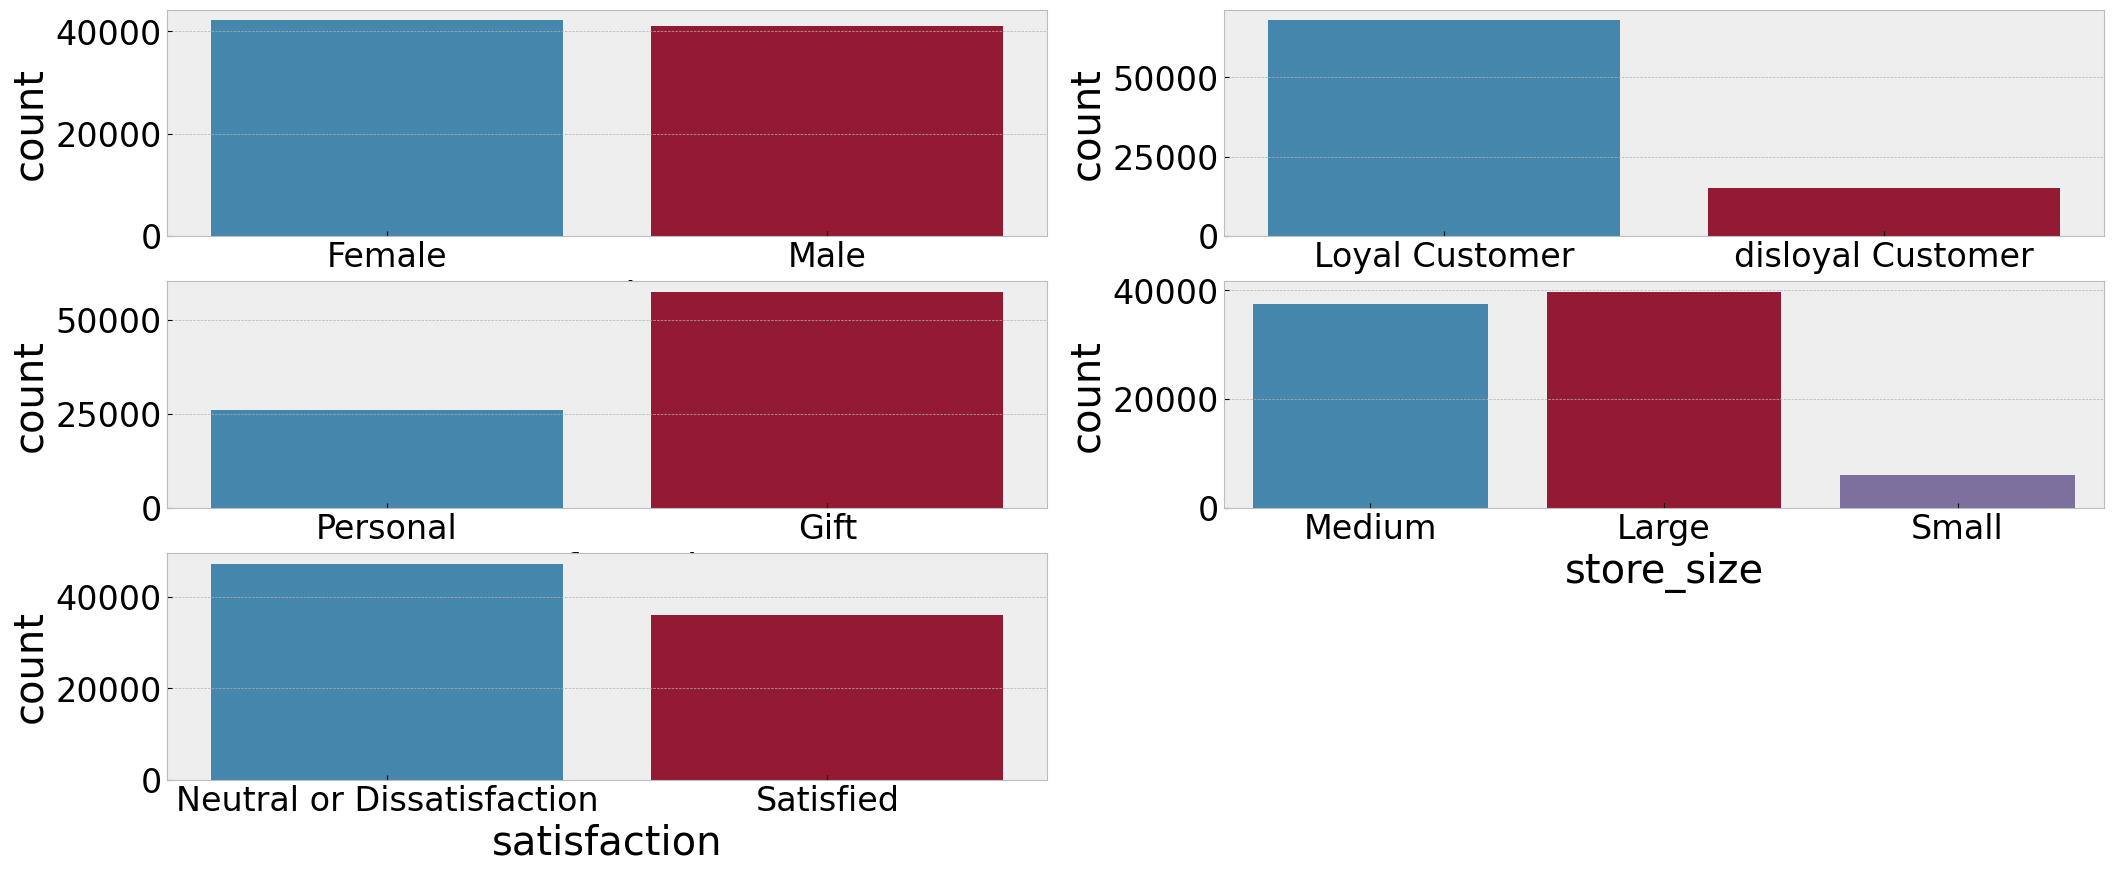

In [14]:
plt.subplot(3, 2, 1)
sns.countplot(x='gender', data=categorical_attributes)

plt.subplot(3, 2, 2)
sns.countplot(x='customer_type', data=categorical_attributes)

plt.subplot(3, 2, 3)
sns.countplot(x='type_of_purchase', data=categorical_attributes)

plt.subplot(3, 2, 4)
sns.countplot(x='store_size', data=categorical_attributes)

plt.subplot(3, 2, 5)
sns.countplot(x='satisfaction', data=categorical_attributes);

- verificar metragem padrão dos eua para store_distance afim de validar os valores máximos.

# 2.0 Feature Engineering

In [198]:
df2 = df1.copy()

# 3.0 Filtragem de variáveis

In [199]:
df3 = df2.copy()

# 4.0 Análise exploratória dos dados

In [200]:
df4 = df3.copy()

#Ter uma descrição das colunas com base no conhecimento de negocio de loja de roupas

# AGE 
# relação com Kids entertainment ( crianças, Pais [30 anos])

#type_of_purchase



#Store distance
# se refere a distância do cliente para a loja ou a distância da loja concorrente mais próxima
# Investigar se existe alguma relação com store location/delivery_delay/open_close_time e a satisfação do cliente
# 

#InStore wifi - Corresponde ao número de roteador? Validar essa hipótese comparando com o tamanho da loja.
#Também pode ser a qualidade do wifi, se for então deverá ter muitos dados dispersos.
#  A média entre os clientes satisfeitos é menor 


#Self-store:
# poderia ser um painel para auto-atendimento
# Existe alguma relação entre o tamanho da loja e o autoatendimento com a satisfação do cliente

# Delivery_delay
#Hip 1: Quem não preencheu Delivery delay in minutes foi porque comprou em loja física
#Hip 2: Quem não preencheu Delivery delay in minutes foi porque estava insatisfeito

# Store_distance
#verificar metragem padrão dos eua para store_distance afim de validar os valores máximos.



In [190]:
linhas = df4["satisfaction"] == "Satisfied"
df_aux = df4.loc[linhas,:]
df_aux.describe()

,id,age,store_distance,instore_wifi,open_close_time_convenient,easy_of_online_shopping,store_location,toilet_cleaning,dressing_room,waiting_room,kids_entertainment,seller_service,showroom,self-store,purchase_service,store_service,cleanliness,carrier_delay_in_minutes,delivery_delay_in_minutes
count,35957.000,35957.000,35957.000,35957.000,35957.000,35957.000,35957.000,35957.000,35957.000,35957.000,35957.000,35957.000,35957.000,35957.000,35957.000,35957.000,35957.000,35957.000,35957.000
mean,65549.824,41.708,1530.166,3.159,2.970,3.032,2.978,3.520,4.025,3.964,3.959,3.859,3.823,3.964,3.648,3.967,3.738,12.574,12.546
std,37226.531,12.771,1128.307,1.590,1.555,1.578,1.376,1.235,1.195,1.145,1.080,1.125,1.174,1.101,1.158,1.093,1.145,35.511,36.065
min,2.000,7.000,31.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,1.000,1.000,0.000,1.000,1.000,1.000,1.000,0.000,0.000
25%,33655.000,32.000,526.000,2.000,2.000,2.000,2.000,3.000,4.000,4.000,4.000,3.000,3.000,4.000,3.000,4.000,3.000,0.000,0.000
50%,65959.000,43.000,1250.000,4.000,3.000,3.000,3.000,4.000,4.000,4.000,4.000,4.000,4.000,4.000,4.000,4.000,4.000,0.000,0.000
75%,97562.000,51.000,2404.000,5.000,4.000,4.000,4.000,5.000,5.000,5.000,5.000,5.000,5.000,5.000,5.000,5.000,5.000,9.000,8.000
max,129879.000,85.000,4983.000,5.000,5.000,5.000,5.000,5.000,5.000,5.000,5.000,5.000,5.000,5.000,5.000,5.000,5.000,1305.000,1280.000


## 4.1 Analise Univariada

In [46]:
df4.describe()


,id,age,store_distance,instore_wifi,open_close_time_convenient,easy_of_online_shopping,store_location,toilet_cleaning,dressing_room,waiting_room,kids_entertainment,seller_service,showroom,self-store,purchase_service,store_service,cleanliness,carrier_delay_in_minutes,delivery_delay_in_minutes
count,83123.000,83123.000,83123.000,83123.000,83123.000,83123.000,83123.000,83123.000,83123.000,83123.000,83123.000,83123.000,83123.000,83123.000,83123.000,83123.000,83123.000,83123.000,83123.000
mean,65059.540,39.341,1188.665,2.730,3.058,2.759,2.978,3.201,3.247,3.436,3.355,3.384,3.354,3.630,3.306,3.639,3.282,14.852,15.164
std,37425.968,15.124,996.941,1.328,1.527,1.399,1.277,1.328,1.349,1.319,1.332,1.287,1.314,1.181,1.265,1.175,1.311,38.495,38.931
min,1.000,7.000,31.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000
25%,32773.000,27.000,414.000,2.000,2.000,2.000,2.000,2.000,2.000,2.000,2.000,2.000,2.000,3.000,3.000,3.000,2.000,0.000,0.000
50%,65078.000,40.000,842.000,3.000,3.000,3.000,3.000,3.000,3.000,4.000,4.000,4.000,4.000,4.000,3.000,4.000,3.000,0.000,0.000
75%,97500.500,51.000,1739.000,4.000,4.000,4.000,4.000,4.000,4.000,5.000,4.000,4.000,4.000,5.000,4.000,5.000,4.000,12.000,13.000
max,129879.000,85.000,4983.000,5.000,5.000,5.000,5.000,5.000,5.000,5.000,5.000,5.000,5.000,5.000,5.000,5.000,5.000,1592.000,1584.000


In [51]:
my_report = sweetviz.analyze( df4 )
my_report.show_html()

Done! Use 'show' commands to display/save.   |██████████| [100%]   00:03 -> (00:00 left)
Report SWEETVIZ_REPORT.html was generated! NOTEBOOK/COLAB USERS: the web browser MAY not pop up, regardless, the report IS saved in your notebook/colab files.


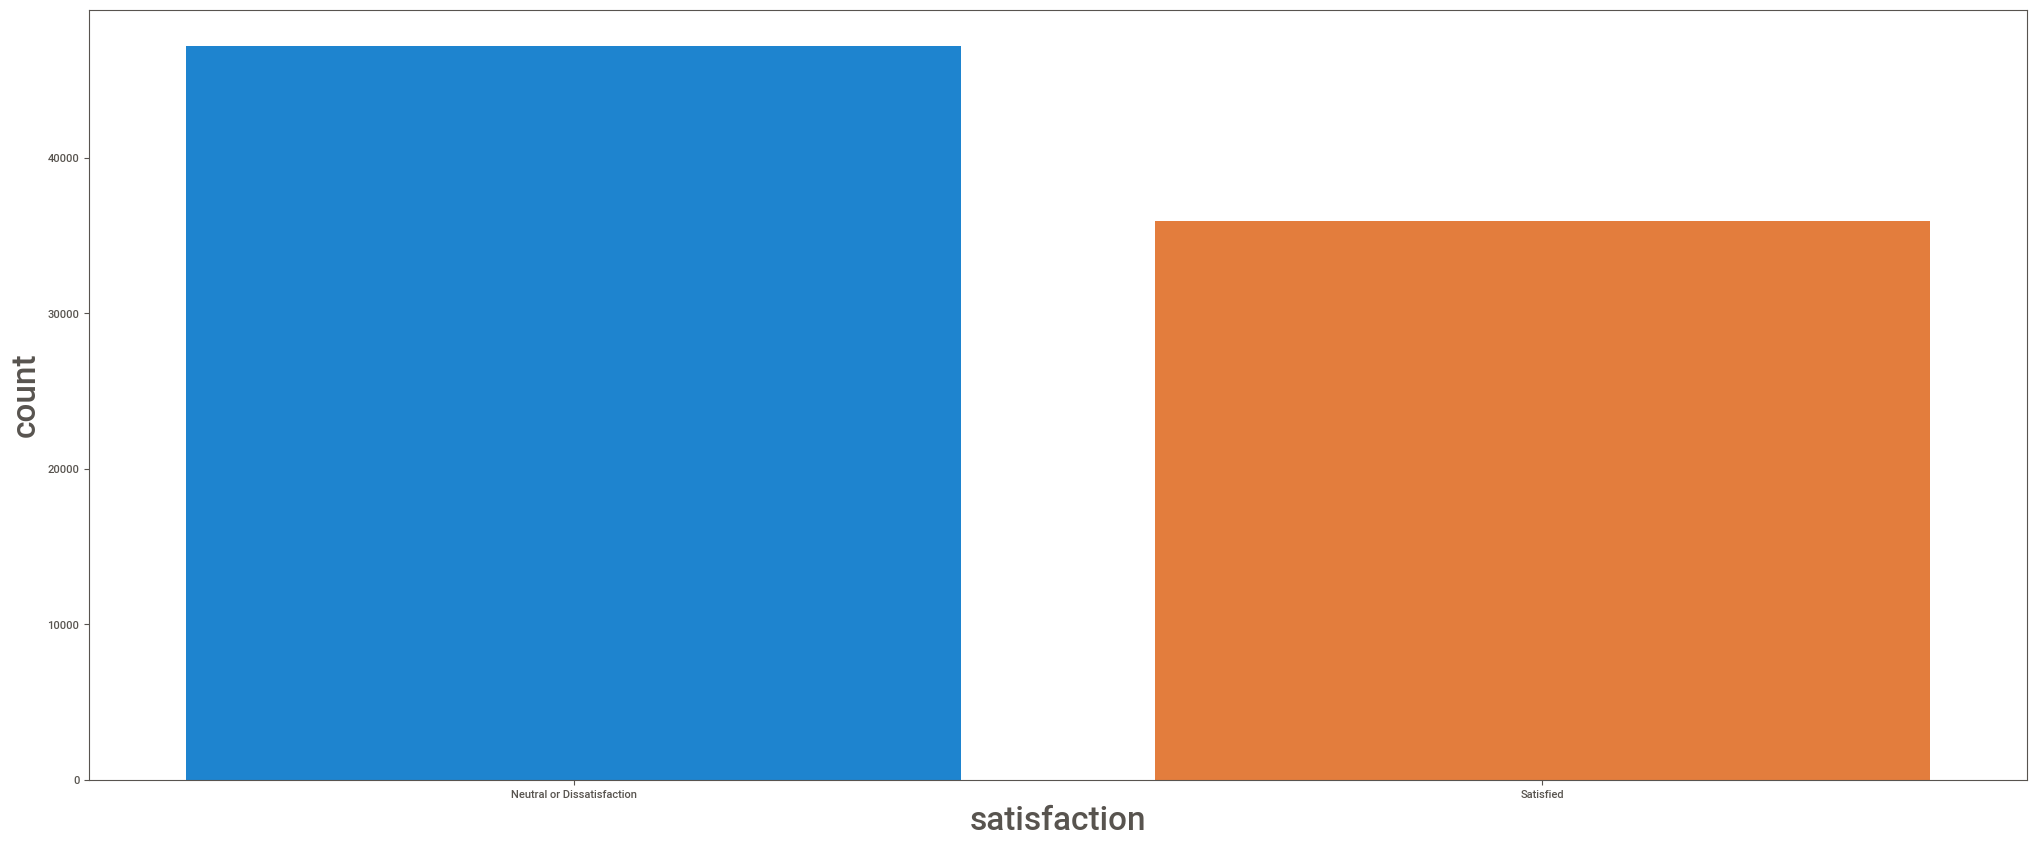

In [66]:
# variavel resposta
sns.countplot( x=df4['satisfaction'] );

Conclusões:

1. 

## 4.2 Analise Bivariada

In [139]:
#InStore wifi - Corresponde ao número de roteador? Validar essa hipótese comparando com o tamanho da loja.
#Também pode ser a qualidade do wifi, se for então deverá ter muitos dados dispersos.
import plotly.express as px
cols = ["store_size","instore_wifi"]
df_aux = df4.loc[:,cols].groupby("store_size").mean().reset_index()
fig = px.pie(df_aux, values = "instore_wifi", names ="store_size")
fig



In [144]:
#Self-store:
# poderia ser um painel para auto-atendimento
# Existe alguma relação entre o tamanho da loja e o autoatendimento com a satisfação do cliente

cols = ["store_size","self-store"]
df_aux = df4.loc[:,cols].groupby("store_size").mean().reset_index()
fig = px.bar(df_aux, y = "self-store", x ="store_size")
fig



## 4.3 Analise Multivariada

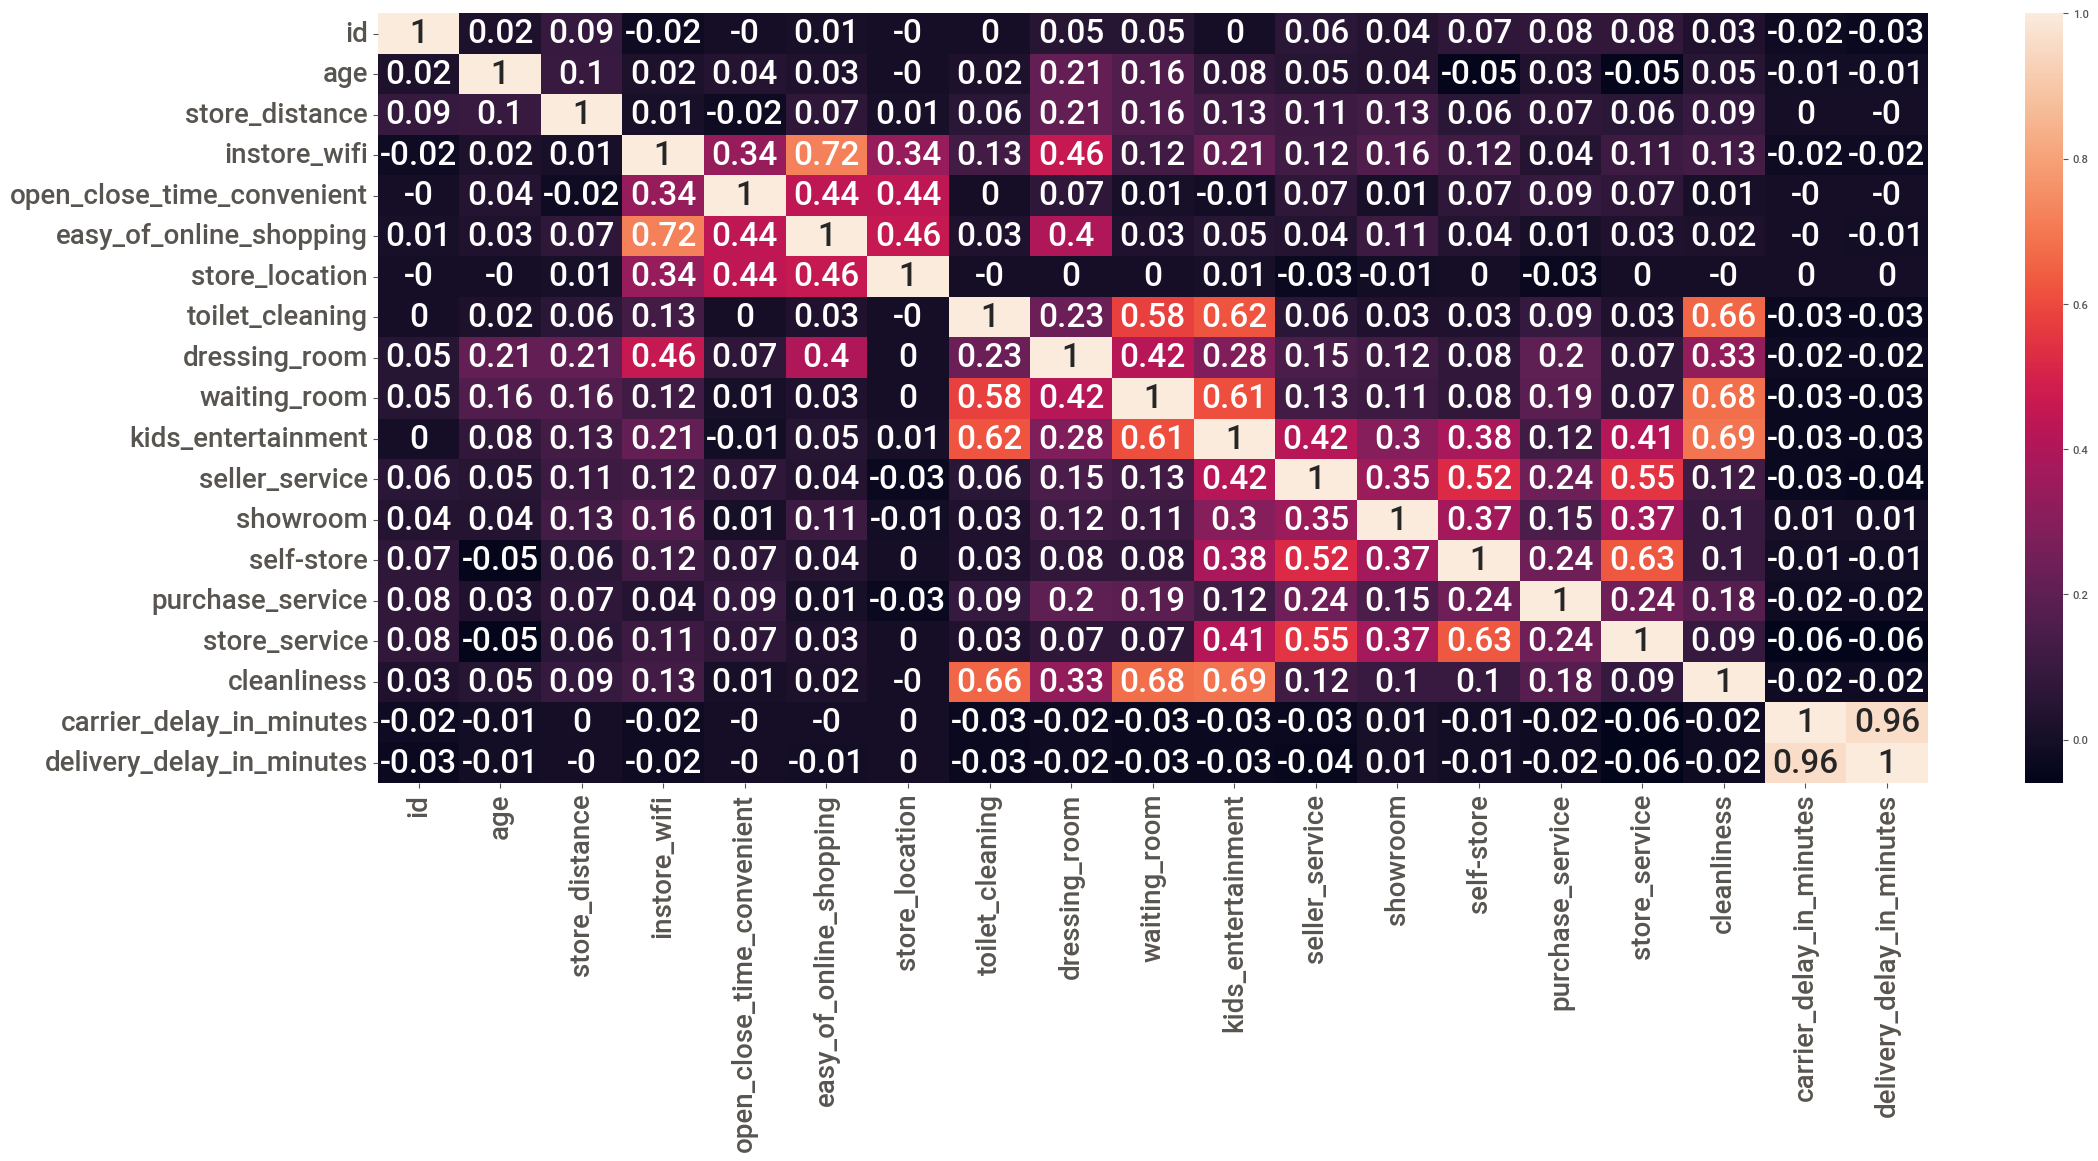

In [170]:
# numerical
num_attributes = df4.select_dtypes(include='number')

correlation = num_attributes.corr( method='pearson' )

sns.heatmap( correlation.round(2), annot=True )

plt.tick_params(axis='both', labelsize=20);

In [130]:
# média das correlação de uma variável numéricas com as demais
correlation.mean(axis=1).sort_values(ascending=False)

kids_entertainment           0.275
waiting_room                 0.228
dressing_room                0.225
cleanliness                  0.223
instore_wifi                 0.209
seller_service               0.206
self-store                   0.196
store_service                0.192
toilet_cleaning              0.186
easy_of_online_shopping      0.182
showroom                     0.180
purchase_service             0.153
open_close_time_convenient   0.139
store_distance               0.123
store_location               0.115
age                          0.091
carrier_delay_in_minutes     0.089
delivery_delay_in_minutes    0.086
id                           0.080
dtype: float64

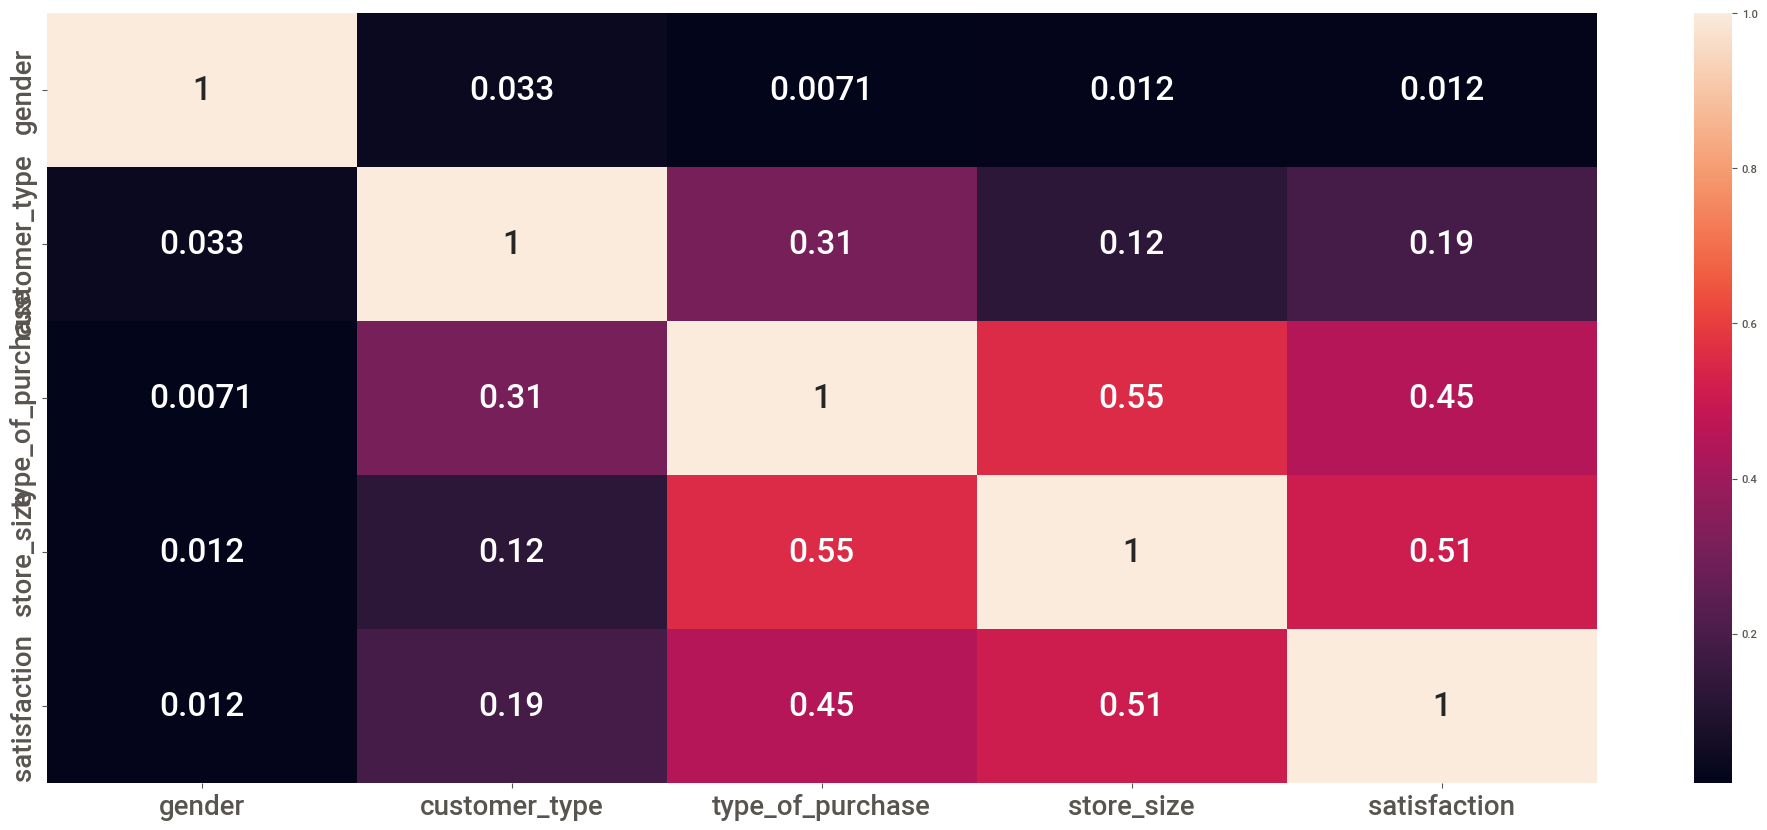

In [120]:
# categorical
def crammer_v(x, y):
    cm = pd.crosstab(x, y).values

    chi2 = stats.chi2_contingency(cm)[0]
    n = cm.sum()
    r, k = cm.shape

    chi2corr = max( 0, chi2 - (k-1)*(r-1)/(n-1) )

    rcorr = r - (r-1)**2 / (n-1)
    kcorr = k - (k-1)**2 / (n-1)

    return np.sqrt( (chi2corr/n) / min(rcorr-1, kcorr-1) )


cat_attributes = df4.select_dtypes(exclude='number')
selected_cols = cat_attributes.columns
cols_permutation = list(product(selected_cols, repeat=2))

v_values = [ crammer_v( cat_attributes[col1], cat_attributes[col2] ) for col1, col2 in cols_permutation ]

data = np.array(v_values).reshape(5, 5)


cramer_correlation = pd.DataFrame(data, columns=selected_cols, index=selected_cols)
#cramer_correlation

sns.heatmap(cramer_correlation, annot=True)
plt.tick_params(axis='both', labelsize=20);

In [125]:
cramer_correlation['satisfaction']

gender             0.012
customer_type      0.187
type_of_purchase   0.449
store_size         0.507
satisfaction       1.000
Name: satisfaction, dtype: float64

# 5.0 Preparação dos dados

In [201]:
df5 = df4.copy()

In [179]:
# # divisão de dados
# from sklearn.model_selection import train_test_split

# X = df5.drop(['satisfaction'], axis=1)
# y = df5['satisfaction'].copy()

# X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.2, random_state=42 )

In [202]:
le = LabelEncoder()

df5['gender'] = le.fit_transform( df5['gender'] )
x_val['gender'] = le.transform( x_val['gender'] )
test_data['gender'] = le.transform( test_data['gender'] )

df5['customer_type'] = le.fit_transform( df5['customer_type'] )
x_val['customer_type'] = le.transform( x_val['customer_type'] )
test_data['customer_type'] = le.transform( test_data['customer_type'] )

df5['type_of_purchase'] = le.fit_transform( df5['type_of_purchase'] )
x_val['type_of_purchase'] = le.transform( x_val['type_of_purchase'] )
test_data['type_of_purchase'] = le.transform( test_data['type_of_purchase'] )

df5['store_size'] = le.fit_transform( df5['store_size'] )
x_val['store_size'] = le.transform( x_val['store_size'] )
test_data['store_size'] = le.transform( test_data['store_size'] )

df5['satisfaction'] = le.fit_transform( df5['satisfaction'] )
y_val = le.transform( y_val )

<AxesSubplot: >

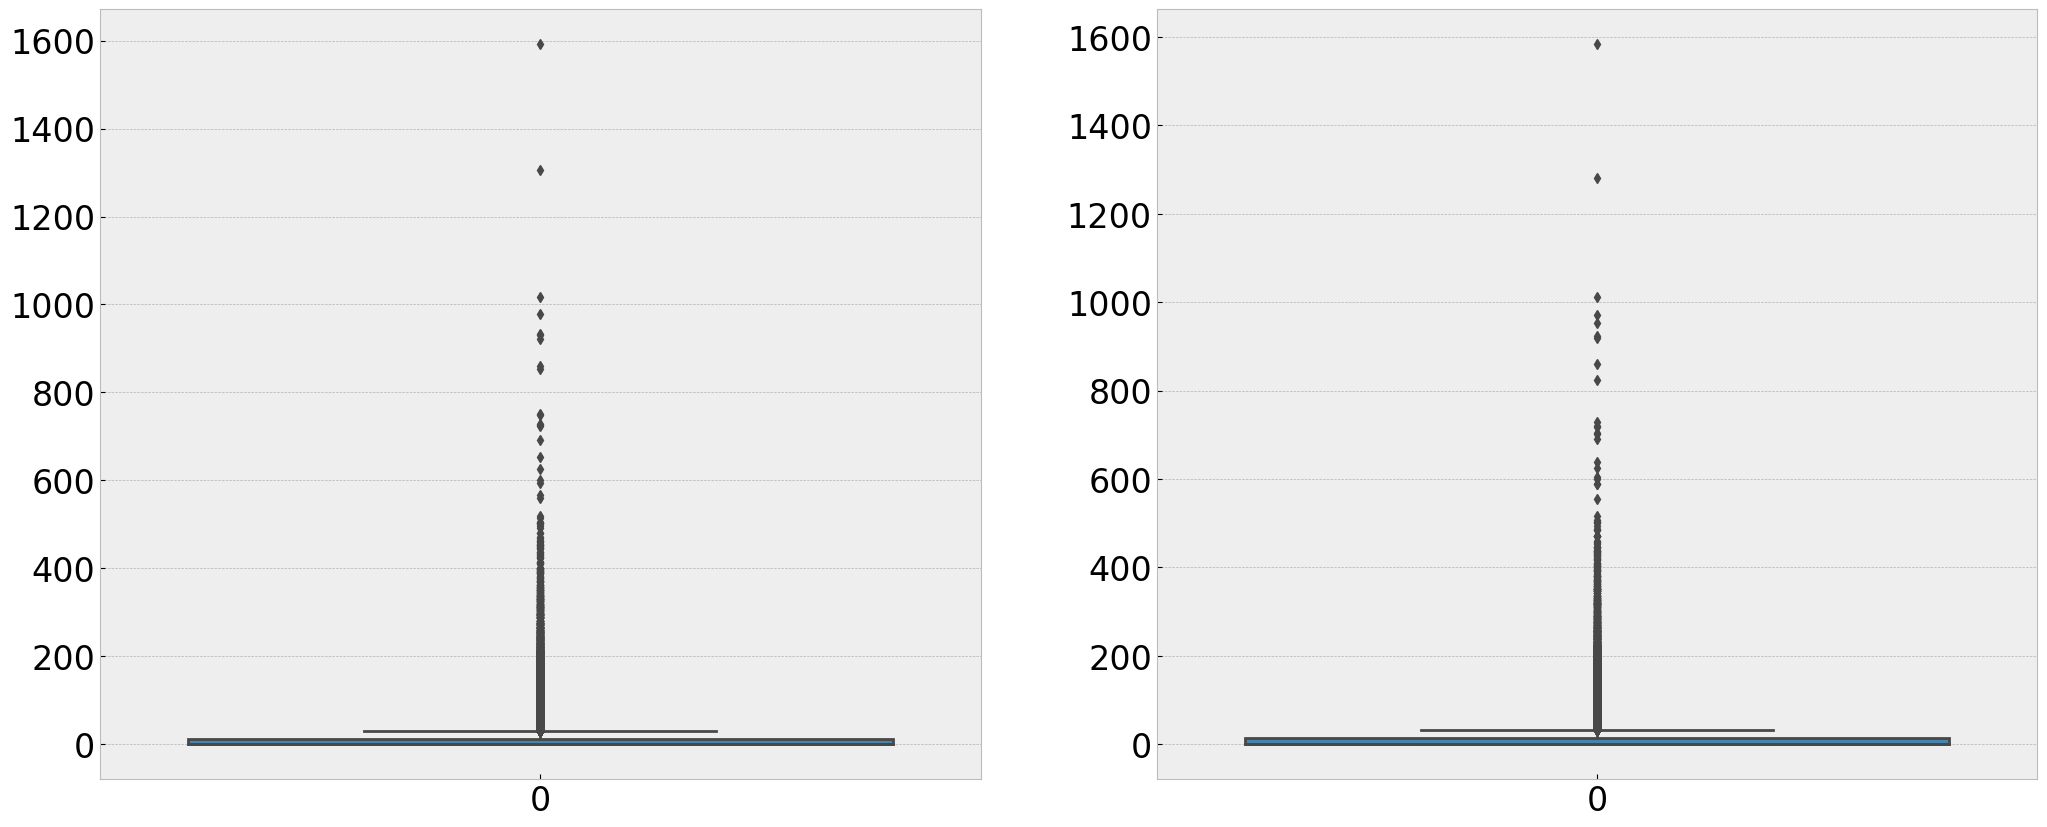

In [22]:
import matplotlib.pyplot as plt
import seaborn as sns


#numerical5 = df5.select_dtypes( include=['int64', 'float64'] )
#categorical5 = df5.select_dtypes( exclude=['int64', 'float64'] )

fig, axes = plt.subplots(1, 2)
sns.boxplot( df5['carrier_delay_in_minutes'], ax=axes[0] )
sns.boxplot( df5['delivery_delay_in_minutes'], ax=axes[1] )

## Reescaling

In [78]:
a = df4.select_dtypes(include=['int64','float64'])
a.columns

Index(['id', 'age', 'store_distance', 'instore_wifi',
       'open_close_time_convenient', 'easy_of_online_shopping',
       'store_location', 'toilet_cleaning', 'dressing_room', 'waiting_room',
       'kids_entertainment', 'seller_service', 'showroom', 'self-store',
       'purchase_service', 'store_service', 'cleanliness',
       'carrier_delay_in_minutes', 'delivery_delay_in_minutes'],
      dtype='object')

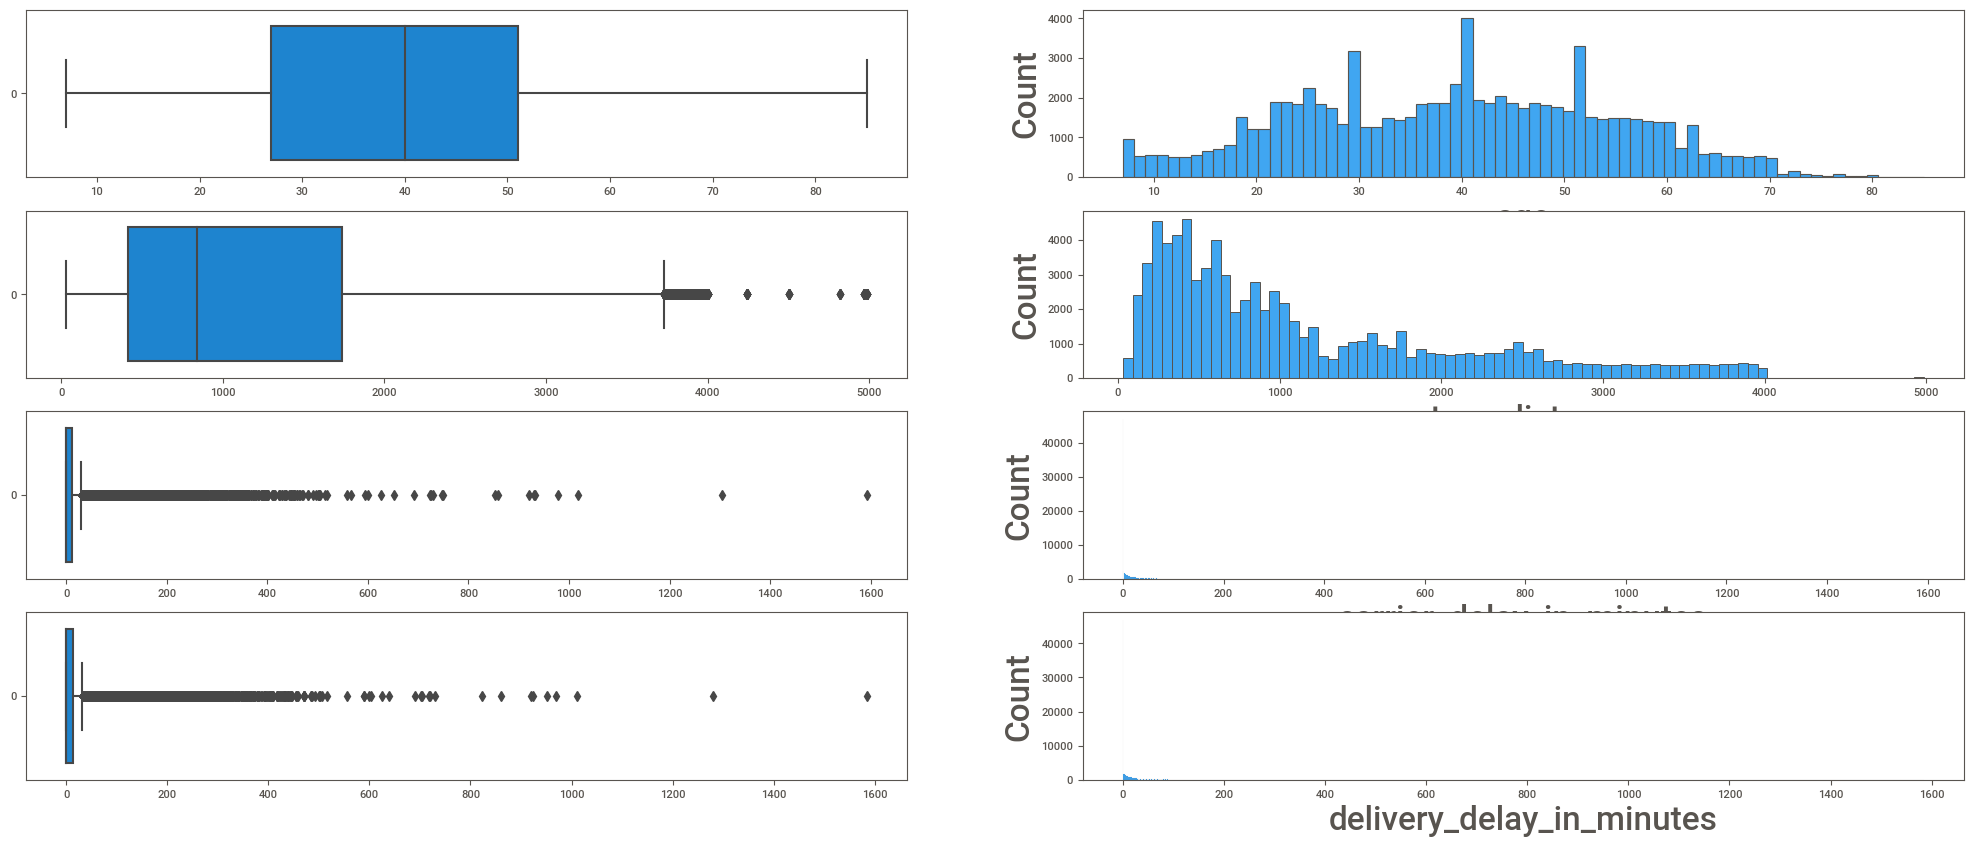

In [107]:
plt.subplot(4,2,1)
sns.boxplot(df5['age'],orient='h');

plt.subplot(4,2,2)
aux00 = df5.loc[:, 'age']
sns.histplot(aux00);

plt.subplot(4,2,3)
sns.boxplot(df5['store_distance'],orient='h');

plt.subplot(4,2,4)
aux00 = df5.loc[:, 'store_distance']
sns.histplot(aux00);

plt.subplot(4,2,5)
sns.boxplot(df5['carrier_delay_in_minutes'],orient='h');

plt.subplot(4,2,6)
aux00 = df5.loc[:, 'carrier_delay_in_minutes']
sns.histplot(aux00);

plt.subplot(4,2,7)
sns.boxplot(df5['delivery_delay_in_minutes'],orient='h');

plt.subplot(4,2,8)
aux00 = df5.loc[:, 'delivery_delay_in_minutes']
sns.histplot(aux00);

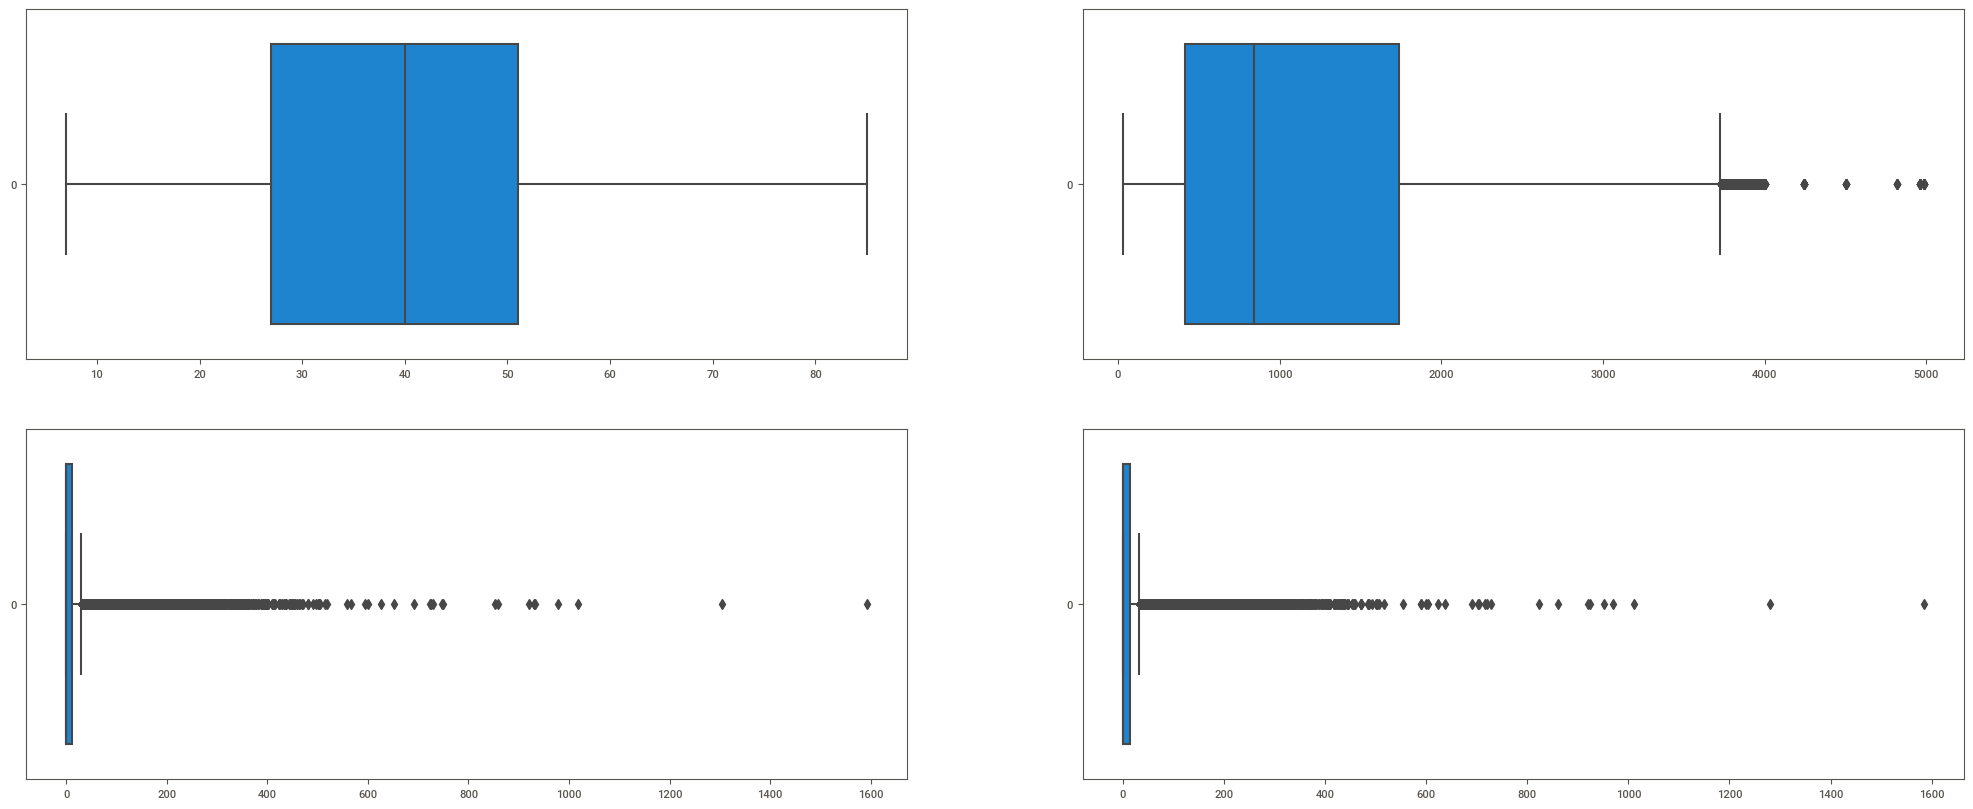

In [111]:
#Verificando se tem outliers

plt.subplot(2,2,1)
sns.boxplot(df5['age'],orient='h');

plt.subplot(2,2,2)
sns.boxplot(df5['store_distance'],orient='h');

plt.subplot(2,2,3)
sns.boxplot(df5['carrier_delay_in_minutes'],orient='h');

plt.subplot(2,2,4)
sns.boxplot(df5['delivery_delay_in_minutes'],orient='h');


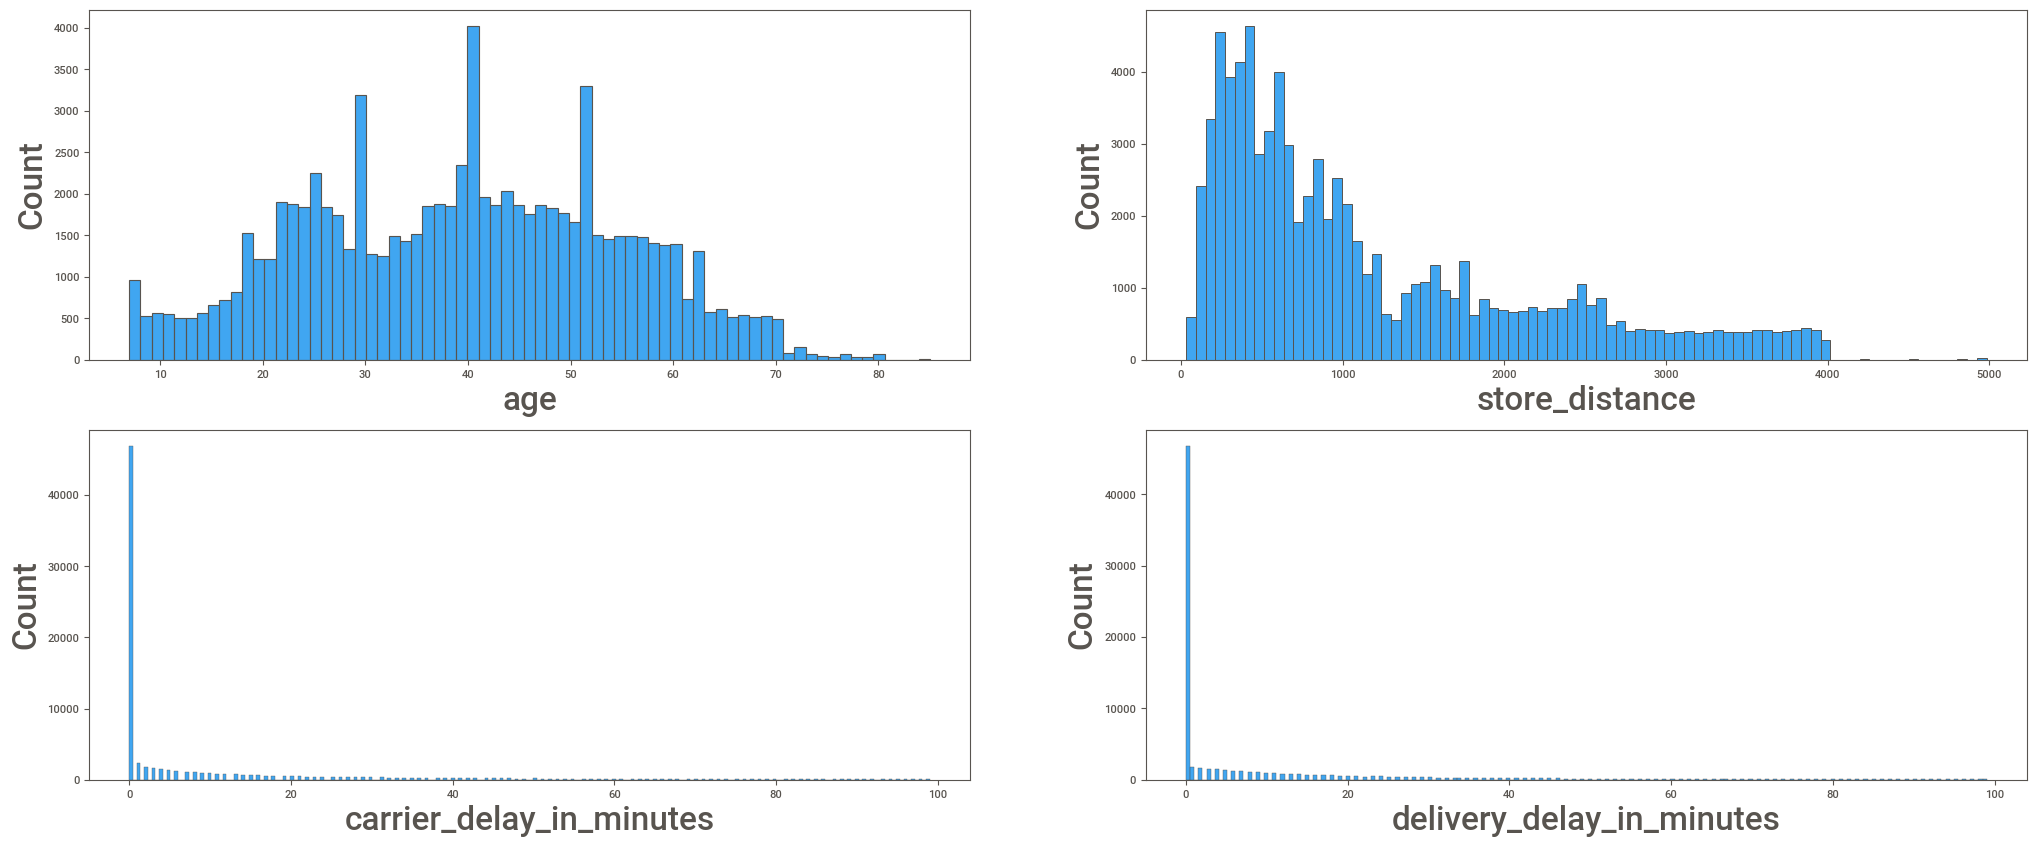

In [122]:
#Verificando a distribuição

plt.subplot(2,2,1)
aux00 = df5.loc[:, 'age']
sns.histplot(aux00); #Distribuição não normal - MMS

plt.subplot(2,2,2)
aux00 = df5.loc[:, 'store_distance']
sns.histplot(aux00);  #Distribuição não normal - MMS

plt.subplot(2,2,3)
aux00 = df5.loc[df5['carrier_delay_in_minutes'] < 100, 'carrier_delay_in_minutes']
sns.histplot(aux00); #Muitos outliers - Robust Scaler

plt.subplot(2,2,4)
aux00 = df5.loc[df5['delivery_delay_in_minutes'] < 100, 'delivery_delay_in_minutes']
sns.histplot(aux00); #Muitos outliers - Robust Scaler

In [203]:
from sklearn.preprocessing import RobustScaler,MinMaxScaler

rs = RobustScaler()
mms = MinMaxScaler()

#'age'
df5['age'] = mms.fit_transform(df5[['age']].values)
x_val['age'] = mms.transform(x_val[['age']].values)
test_data['age'] = mms.transform(test_data[['age']].values)

#'store_distance'
df5['store_distance'] = mms.fit_transform(df5[['store_distance']].values)
x_val['store_distance'] = mms.transform(x_val[['store_distance']].values)
test_data['store_distance'] = mms.transform(test_data[['store_distance']].values)

#'carrier_delay_in_minutes'
df5['carrier_delay_in_minutes'] = rs.fit_transform(df5[['carrier_delay_in_minutes']].values)
x_val['carrier_delay_in_minutes'] = rs.transform(x_val[['carrier_delay_in_minutes']].values)
test_data['carrier_delay_in_minutes'] = rs.transform(test_data[['carrier_delay_in_minutes']].values)

#'delivery_delay_in_minutes'
df5['delivery_delay_in_minutes'] = rs.fit_transform(df5[['delivery_delay_in_minutes']].values)
x_val['delivery_delay_in_minutes'] = rs.transform(x_val[['delivery_delay_in_minutes']].values)
test_data['delivery_delay_in_minutes'] = rs.transform(test_data[['delivery_delay_in_minutes']].values)


In [204]:
#Aplicando MMS nas colunas que são notas

#'instore_wifi'
df5['instore_wifi'] = mms.fit_transform(df5[['instore_wifi']].values)
x_val['instore_wifi'] = mms.transform(x_val[['instore_wifi']].values)
test_data['instore_wifi'] = mms.transform(test_data[['instore_wifi']].values)

#'open_close_time_convenient'
df5['open_close_time_convenient'] = mms.fit_transform(df5[['open_close_time_convenient']].values)
x_val['open_close_time_convenient'] = mms.transform(x_val[['open_close_time_convenient']].values)
test_data['open_close_time_convenient'] = mms.transform(test_data[['open_close_time_convenient']].values)

#'easy_of_online_shopping'
df5['easy_of_online_shopping'] = mms.fit_transform(df5[['easy_of_online_shopping']].values)
x_val['easy_of_online_shopping'] = mms.transform(x_val[['easy_of_online_shopping']].values)
test_data['easy_of_online_shopping'] = mms.transform(test_data[['easy_of_online_shopping']].values)

#'store_location'
df5['store_location'] = mms.fit_transform(df5[['store_location']].values)
x_val['store_location'] = mms.transform(x_val[['store_location']].values)
test_data['store_location'] = mms.transform(test_data[['store_location']].values)

#'toilet_cleaning'
df5['toilet_cleaning'] = mms.fit_transform(df5[['toilet_cleaning']].values)
x_val['toilet_cleaning'] = mms.transform(x_val[['toilet_cleaning']].values)
test_data['toilet_cleaning'] = mms.transform(test_data[['toilet_cleaning']].values)

#'dressing_room'
df5['dressing_room'] = mms.fit_transform(df5[['dressing_room']].values)
x_val['dressing_room'] = mms.transform(x_val[['dressing_room']].values)
test_data['dressing_room'] = mms.transform(test_data[['dressing_room']].values)

#'waiting_room'
df5['waiting_room'] = mms.fit_transform(df5[['waiting_room']].values)
x_val['waiting_room'] = mms.transform(x_val[['waiting_room']].values)
test_data['waiting_room'] = mms.transform(test_data[['waiting_room']].values)

#'kids_entertainment'
df5['kids_entertainment'] = mms.fit_transform(df5[['kids_entertainment']].values)
x_val['kids_entertainment'] = mms.transform(x_val[['kids_entertainment']].values)
test_data['kids_entertainment'] = mms.transform(test_data[['kids_entertainment']].values)

#'seller_servicet'
df5['seller_service'] = mms.fit_transform(df5[['seller_service']].values)
x_val['seller_service'] = mms.transform(x_val[['seller_service']].values)
test_data['seller_service'] = mms.transform(test_data[['seller_service']].values)

#'showroom'
df5['showroom'] = mms.fit_transform(df5[['showroom']].values)
x_val['showroom'] = mms.transform(x_val[['showroom']].values)
test_data['showroom'] = mms.transform(test_data[['showroom']].values)

#'self-storet'
df5['self-store'] = mms.fit_transform(df5[['self-store']].values)
x_val['self-store'] = mms.transform(x_val[['self-store']].values)
test_data['self-store'] = mms.transform(test_data[['self-store']].values)

#'purchase_service'
df5['purchase_service'] = mms.fit_transform(df5[['purchase_service']].values)
x_val['purchase_service'] = mms.transform(x_val[['purchase_service']].values)
test_data['purchase_service'] = mms.transform(test_data[['purchase_service']].values)

#'store_service'
df5['store_service'] = mms.fit_transform(df5[['store_service']].values)
x_val['store_service'] = mms.transform(x_val[['store_service']].values)
test_data['store_service'] = mms.transform(test_data[['store_service']].values)

#'cleanliness'
df5['cleanliness'] = mms.fit_transform(df5[['cleanliness']].values)
x_val['cleanliness'] = mms.transform(x_val[['cleanliness']].values)
test_data['cleanliness'] = mms.transform(test_data[['cleanliness']].values)

In [205]:
test_data.head()

,id,gender,customer_type,age,type_of_purchase,store_size,store_distance,instore_wifi,open_close_time_convenient,easy_of_online_shopping,...,waiting_room,kids_entertainment,seller_service,showroom,self-store,purchase_service,store_service,cleanliness,carrier_delay_in_minutes,delivery_delay_in_minutes
0,19556,0,0,0.577,0,1,0.026,1.000,0.800,0.600,...,0.600,1.000,1.000,1.000,1.000,0.400,1.000,1.000,4.167,3.385
1,90035,0,0,0.372,0,0,0.572,0.200,0.200,0.600,...,1.000,0.800,0.800,0.800,0.750,0.600,0.800,1.000,0.000,0.000
2,12360,1,1,0.167,0,1,0.033,0.400,0.000,0.400,...,0.400,0.400,0.800,0.200,0.500,0.400,0.400,0.400,0.000,0.000
3,77959,1,0,0.474,0,0,0.676,0.000,0.000,0.000,...,0.800,0.200,0.200,0.200,0.000,0.600,0.200,0.800,0.000,0.462
4,36875,0,0,0.538,0,1,0.232,0.400,0.600,0.800,...,0.400,0.400,0.400,0.400,0.250,0.800,0.400,0.800,0.000,1.538


# 6.0 Feature Selection

In [206]:
df6 = df5.copy()
#data preparation
x_train_n = df6.drop(['id','satisfaction'],axis=1)
y_train_n = y_train.values

In [151]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel

rf = RandomForestClassifier(n_estimators = 100)

sel = SelectFromModel( rf )

sel.fit(x_train_n, y_train_n)

SelectFromModel(estimator=RandomForestClassifier())

In [153]:
selected_feat = x_train_n.columns[ (sel.get_support()) ]
selected_feat

Index(['type_of_purchase', 'store_size', 'instore_wifi', 'dressing_room',
       'waiting_room', 'kids_entertainment'],
      dtype='object')

In [154]:
rf.fit(x_train_n, y_train_n)

rf.feature_importances_

array([0.00466695, 0.03591246, 0.03370037, 0.0838661 , 0.0910987 ,
       0.04090318, 0.14248425, 0.01932164, 0.03766092, 0.01746946,
       0.01211646, 0.18146765, 0.0439103 , 0.06456511, 0.03056501,
       0.04214841, 0.02145884, 0.02302458, 0.0255315 , 0.02429273,
       0.01112305, 0.01271232])

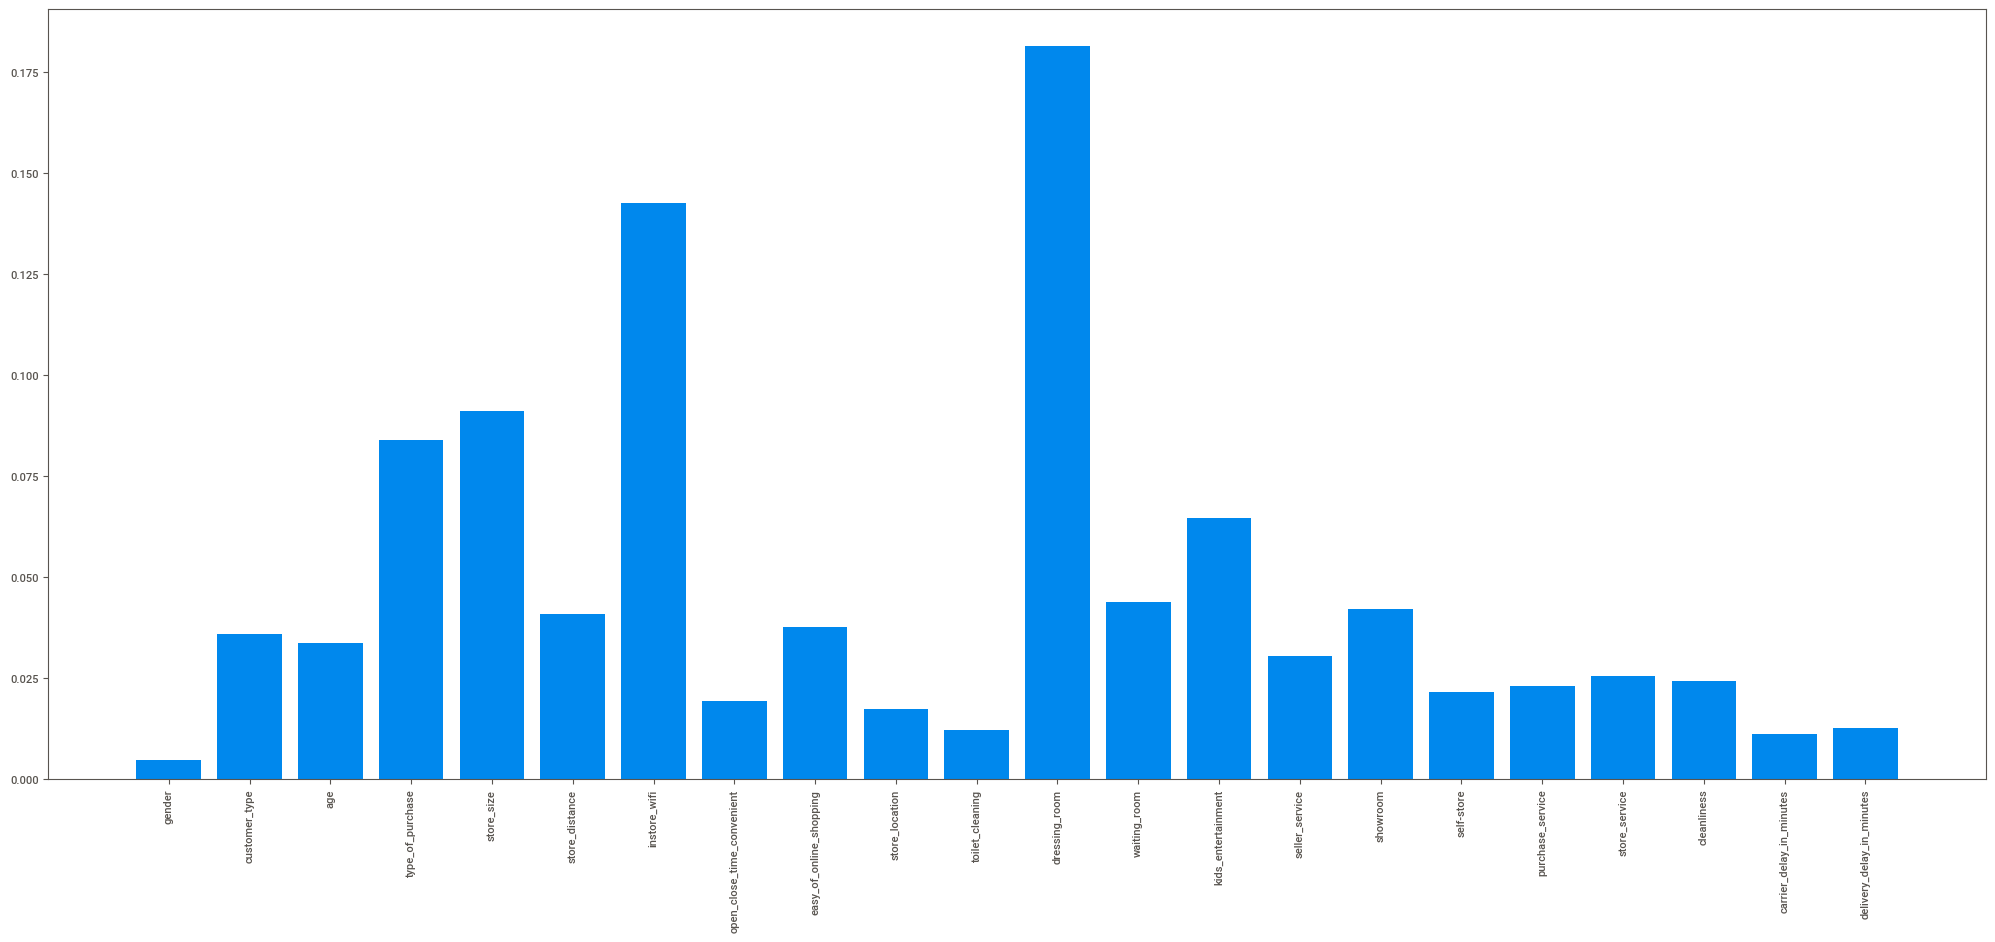

In [156]:
features = x_train_n.columns

plt.bar( features, rf.feature_importances_ )
plt.xticks( rotation=90 );

- dressing_room 

- instore_wifi

- type_of_purchase

- store_size

In [157]:
#Teste de Feature Selection

#model definition
forest = en.ExtraTreesClassifier(n_estimators=250, random_state=0,n_jobs=-1)

forest.fit(x_train_n,y_train_n)

ExtraTreesClassifier(n_estimators=250, n_jobs=-1, random_state=0)

Feature Ranking
                      feature  importance
0            type_of_purchase       0.142
0               dressing_room       0.129
0                instore_wifi       0.127
0                  store_size       0.077
0               customer_type       0.060
0          kids_entertainment       0.055
0                waiting_room       0.047
0     easy_of_online_shopping       0.043
0              seller_service       0.037
0                    showroom       0.034
0                  self-store       0.033
0                 cleanliness       0.031
0            purchase_service       0.030
0               store_service       0.027
0              store_distance       0.026
0                         age       0.021
0  open_close_time_convenient       0.019
0              store_location       0.018
0             toilet_cleaning       0.014
0   delivery_delay_in_minutes       0.011
0    carrier_delay_in_minutes       0.011
0                      gender       0.007


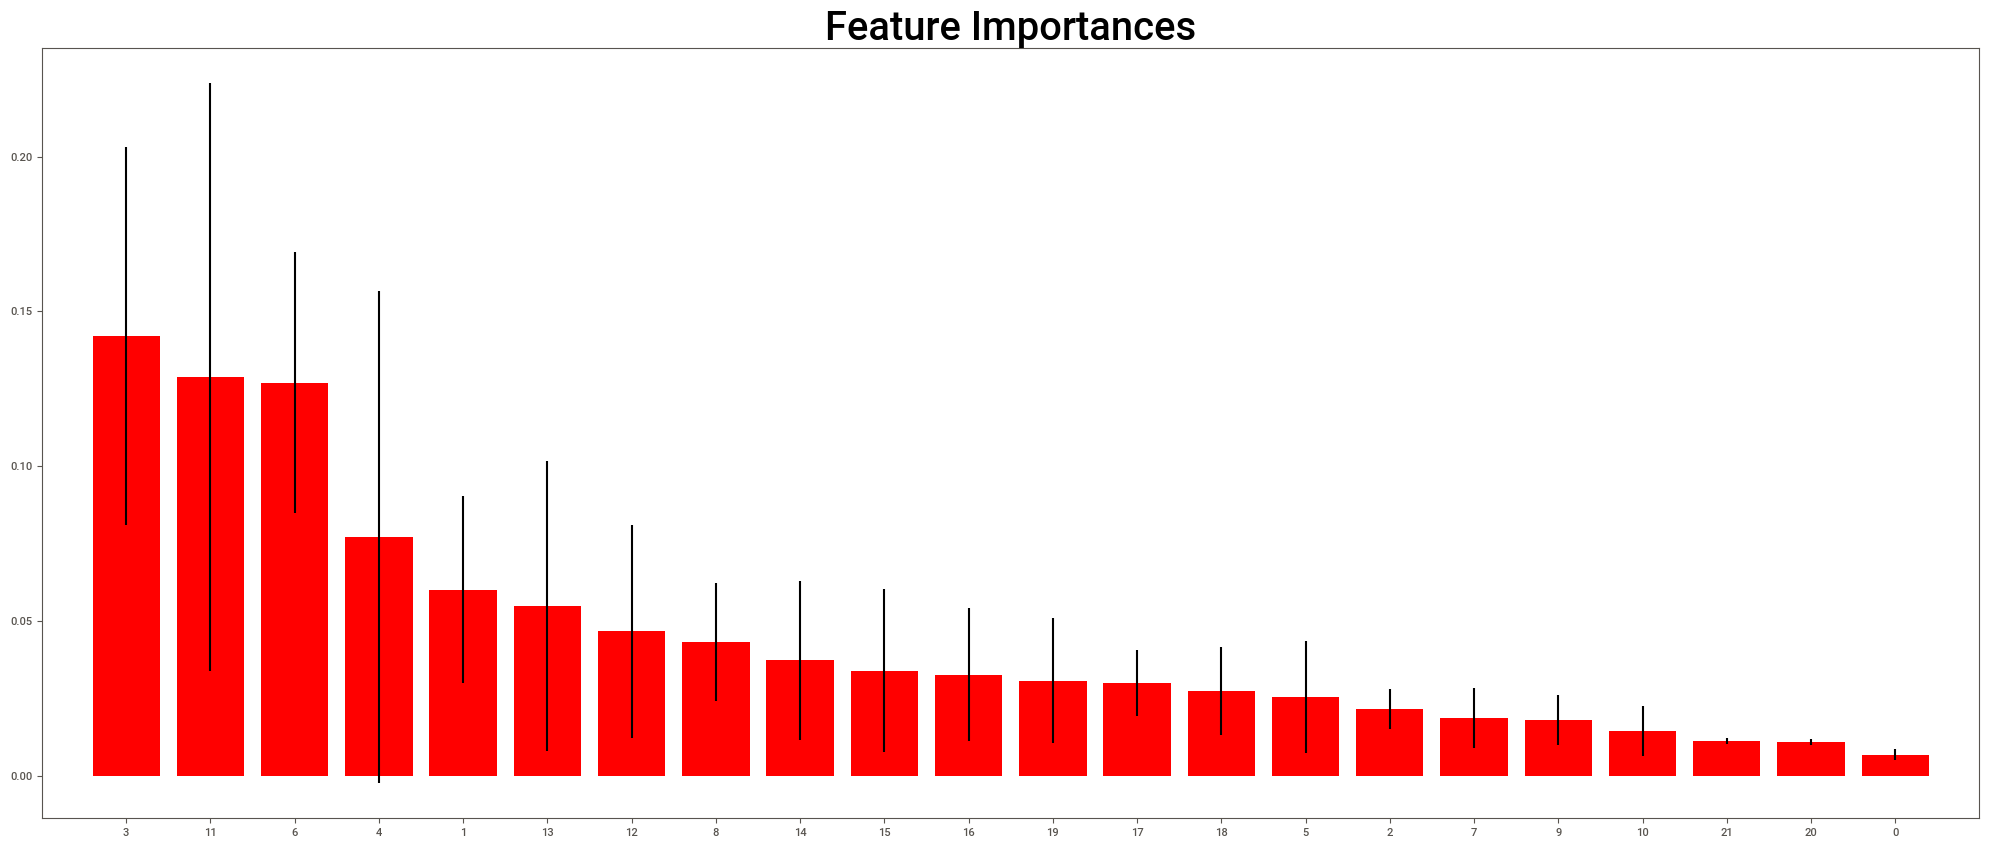

In [158]:
importances = forest.feature_importances_ #Salva as importâncias das features
std = np.std([tree.feature_importances_ for tree in forest.estimators_],axis=0)
indices = np.argsort(importances)[::-1] #Importâncias das árvores ordenadas pelo maior valor

#print the feature ranking
print('Feature Ranking')
df = pd.DataFrame()
for i,j in zip(x_train_n,forest.feature_importances_):
    aux = pd.DataFrame({'feature': i, 'importance': j},index=[0])
    df = pd.concat([df,aux],axis=0)
    
print(df.sort_values('importance',ascending=False))

#Plot the impurity-based feature importances of the forest
plt.figure()
plt.title('Feature Importances')
plt.bar(range(x_train_n.shape[1]),importances[indices],color='r',yerr=std[indices],align='center')
plt.xticks(range(x_train_n.shape[1]),indices)
plt.xlim([-1,x_train_n.shape[1]])
plt.show()

- type_of_purchase

- dressing_room

- instore_wifi

## Boruta

In [44]:
X_train_n_boruta = df6.drop(['id','satisfaction'],axis=1).values
Y_train_n_boruta = y_train.values.ravel()

In [52]:
from boruta                import BorutaPy

#Definindo os datasets para o Boruta
#X_train_n = X_train.drop(['date','sales'],axis=1).values
#Y_train_n = Y_train.values.ravel()

#Definindo o RandomForestRegressor
#rf = RandomForestRegressor(n_jobs=-1)

#Definindo o Boruta
boruta = BorutaPy(forest,n_estimators='auto',verbose=2,random_state=42,max_iter=10).fit(X_train_n_boruta,Y_train_n_boruta)

Iteration: 	1 / 10
Confirmed: 	0
Tentative: 	22
Rejected: 	0
Iteration: 	2 / 10
Confirmed: 	0
Tentative: 	22
Rejected: 	0
Iteration: 	3 / 10
Confirmed: 	0
Tentative: 	22
Rejected: 	0
Iteration: 	4 / 10
Confirmed: 	0
Tentative: 	22
Rejected: 	0
Iteration: 	5 / 10
Confirmed: 	0
Tentative: 	22
Rejected: 	0
Iteration: 	6 / 10
Confirmed: 	0
Tentative: 	22
Rejected: 	0
Iteration: 	7 / 10
Confirmed: 	0
Tentative: 	22
Rejected: 	0
Iteration: 	8 / 10
Confirmed: 	19
Tentative: 	1
Rejected: 	2
Iteration: 	9 / 10
Confirmed: 	19
Tentative: 	1
Rejected: 	2


BorutaPy finished running.

Iteration: 	10 / 10
Confirmed: 	19
Tentative: 	0
Rejected: 	2


In [61]:
cols_selected = boruta.support_.tolist()
cols_selected_boruta = x_train_n.iloc[:,cols_selected].columns.to_list()
cols_selected_boruta

['customer_type',
 'age',
 'type_of_purchase',
 'store_size',
 'store_distance',
 'instore_wifi',
 'open_close_time_convenient',
 'easy_of_online_shopping',
 'store_location',
 'toilet_cleaning',
 'dressing_room',
 'waiting_room',
 'kids_entertainment',
 'seller_service',
 'showroom',
 'self-store',
 'purchase_service',
 'store_service',
 'cleanliness']

In [221]:
cols_not_selected_boruta = list(np.setdiff1d(x_train_n.columns,cols_selected_boruta))
cols_not_selected_boruta

['carrier_delay_in_minutes', 'delivery_delay_in_minutes', 'gender']

In [ ]:
#Rodando o Boruta sem limites de iterações ele ficou em 27 iterações
#Confirmou 20 variáveis e rejeitou duas
#As rejeitadas foram
#['carrier_delay_in_minutes', 'gender']

#As selecionadas foram
#['customer_type','age','type_of_purchase','store_size','store_distance','instore_wifi',
#'open_close_time_convenient','easy_of_online_shopping','store_location','toilet_cleaning',
#'dressing_room','waiting_room','kids_entertainment','seller_service','showroom','self-store',
#'purchase_service','store_service','cleanliness','delivery_delay_in_minutes']

# 7.0 Machine Learning Modeling

In [207]:
# treinamento e avaliação
df7 = df6.drop(columns=['id', 'satisfaction']).copy()
y_train = df6['satisfaction'].copy()

X_val = x_val.drop(columns=['id'])

In [32]:
# cols_selected = ['age', 'instore_wifi',
#        'open_close_time_convenient', 'easy_of_online_shopping',
#        'store_location', 'toilet_cleaning', 'dressing_room', 'waiting_room',
#        'kids_entertainment', 'seller_service', 'showroom', 'self-store',
#        'purchase_service', 'store_service', 'cleanliness']

# #Usar apenas as features selecionadas
# x_train = df7[cols_selected]
# x_val = x_validation[cols_selected]

## 7.1 KNN Classifier

In [211]:
#model definition
knn_model = nh.KNeighborsClassifier(n_neighbors=7, n_jobs=-1)

#model training
knn_model.fit(df7, y_train)

y_hat_knn = knn_model.predict(X_val)

knn_precision = precision_score(y_val, y_hat_knn, average='micro')
print("Micro-Precision:", knn_precision)

# classification_rep = classification_report(y_validation, y_hat_knn)
# print("Relatório de Classificação:\n", classification_rep)

Micro-Precision: 0.9160290650113084


## 7.2 Logistic Regression

In [212]:
lr_model = LogisticRegression(solver='lbfgs', max_iter=1000, class_weight='balanced',
                             tol=1e-1, random_state=42, n_jobs=-1)

#model training
lr_model.fit(df7, y_train)

y_hat_lr = lr_model.predict(X_val)
lr_precision = precision_score(y_val, y_hat_lr, average='micro')
print("Micro-Precision:", lr_precision)

Micro-Precision: 0.8704104711034117


## 7.3 Extras Classifier

In [213]:
#model definition
extra_model = en.ExtraTreesClassifier(n_estimators=100, random_state=0, n_jobs=-1)

#model training
extra_model.fit(df7, y_train)

y_hat_et = extra_model.predict(X_val)
et_precision = precision_score(y_val, y_hat_et, average='micro')
print("Micro-Precision:", et_precision)

# classification_rep = classification_report(y_validation, y_hat_et)
# print("Relatório de Classificação:\n", classification_rep)

Micro-Precision: 0.9613108127616573


## 7.4 Random Forest

In [214]:
#model definition
rf_model = en.RandomForestClassifier(n_estimators=100, random_state=0, n_jobs=-1)

#model training
rf_model.fit(df7, y_train)

y_hat_rf = rf_model.predict(X_val)
rf_precision = precision_score(y_val, y_hat_rf, average='micro')
print("Micro-Precision:", rf_precision)

# classification_rep = classification_report(y_validation, y_hat_et)
# print("Relatório de Classificação:\n", classification_rep)

Micro-Precision: 0.9624657138732496


## 7.5 XGBoost

In [215]:
#model definition
xgb_model = XGBClassifier(random_state=42, n_jobs=-1)

#model training
xgb_model.fit(df7, y_train)

y_hat_xgb = xgb_model.predict(X_val)
xgb_precision = precision_score(y_val, y_hat_xgb, average='micro')
print("Micro-Precision:", xgb_precision)

Micro-Precision: 0.9624175929936


## 7.6 LGBM

In [216]:
#model definition
lgbm_model = LGBMClassifier(random_state=42, n_jobs=-1)

#model training
lgbm_model.fit(df7, y_train)

y_hat_lgbm = lgbm_model.predict(X_val)
lgbm_precision = precision_score(y_val, y_hat_lgbm, average='micro')
print("Micro-Precision:", lgbm_precision)

[LightGBM] [Info] Number of positive: 35957, number of negative: 47166
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.063075 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 932
[LightGBM] [Info] Number of data points in the train set: 83123, number of used features: 22
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.432576 -> initscore=-0.271350
[LightGBM] [Info] Start training from score -0.271350
Micro-Precision: 0.9632837688272942


## 7.7 Catboost

In [217]:
#model definition
cat_model = CatBoostClassifier(random_state=42, verbose=False)

#model training
cat_model.fit(df7, y_train)

y_hat_cat = cat_model.predict(X_val)
cat_precision = precision_score(y_val, y_hat_cat, average='micro')
print("Micro-Precision:", cat_precision)

Micro-Precision: 0.9632837688272942


## 7.7.1 Precision-recall curve

In [169]:
# from sklearn.metrics import precision_recall_curve

# y_hat_proba_cat = cat_model.predict_proba(X_val)[:, 1]

# precision, recall, thresholds = precision_recall_curve(y_val, y_hat_proba_cat)

# best_threshold = 0.5
# best_precision = cat_precision

# for th in thresholds:
#     y_hat_adjusted = (y_hat_proba_cat >= th).astype(int)
#     adjusted_precision = precision_score(y_val, y_hat_adjusted, average='micro')
    
#     if adjusted_precision > best_precision:
#         best_threshold = th
#         best_precision = adjusted_precision

# print("Best threshold:", best_threshold)
# print("Best precision:", best_precision)

KeyboardInterrupt: 

## 7.8 MLP Classifier

In [218]:
from sklearn.neural_network import MLPClassifier

#model definition
mlp_model = MLPClassifier(n_iter_no_change=10, early_stopping=True, random_state=42)

#model training
mlp_model.fit(df7, y_train)

y_hat_mlp = mlp_model.predict(X_val)
mlp_precision = precision_score(y_val, y_hat_mlp, average='micro')
print("Micro-Precision:", mlp_precision)

FloatingPointError: underflow encountered in multiply

## 7.9 Bernoulli

In [219]:
from sklearn.neural_network import BernoulliRBM

#model definition
ber_model = BernoulliRBM(random_state=42)

#model training
ber_model.fit(df7, y_train)

y_hat_ber = ber_model.predict(X_val)
ber_precision = precision_score(y_val, y_hat_ber, average='micro')
print("Micro-Precision:", ber_precision)

FloatingPointError: underflow encountered in matmul

## 7.10 Model performance

In [220]:
precision_dict = {'knn': knn_precision,
                'logistic': lr_precision,
                'extra_tree': et_precision,
                'random_forest': rf_precision,
                'xgb': xgb_precision,
                'lgbm': lgbm_precision,
                'catboost': cat_precision,
                  }

precision_metrics = pd.DataFrame(list(precision_dict.items()), columns=['Model', 'Precision'])
precision_metrics = precision_metrics.sort_values(by=['Precision'], ascending=False)
precision_metrics

,Model,Precision
5,lgbm,0.963
6,catboost,0.963
3,random_forest,0.962
4,xgb,0.962
2,extra_tree,0.961
0,knn,0.916
1,logistic,0.870


# 8.0 Hyper Parameter Fine Tunning

In [222]:
df8 = df7.copy()

# 9.0 Deploy to test

In [224]:
x_test = test_data.drop(columns=['id']).copy()
y_hat_test = lgbm_model.predict(x_test)

In [227]:
final_test = pd.concat([test_data, pd.Series(y_hat_test, name='Satisfaction')], axis=1)

final_test[['id', 'Satisfaction']].to_csv('/data/submission2.csv', index=False)

In [ ]:
# # predição
# #df9 = df8.copy()
# df_test = test_data.copy()

# cols_selected = ['age', 'instore_wifi',
#        'open_close_time_convenient', 'easy_of_online_shopping',
#        'store_location', 'toilet_cleaning', 'dressing_room', 'waiting_room',
#        'kids_entertainment', 'seller_service', 'showroom', 'self-store',
#        'purchase_service', 'store_service', 'cleanliness']
# df_test_to_ml = df_test[cols_selected]
# pred = extra_model.predict(df_test_to_ml)

# df_test['prediction'] = pred

# df_test_submission = df_test.loc[:,['id','prediction']]

In [ ]:
df_test_submission.head()

In [ ]:
df_test.columns

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=dff17627-f4c4-4269-85ce-bfc293329104' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>